In [336]:
import pandas as pd 
import nltk
import re
from nltk.stem import PorterStemmer
import string
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from base_datos_airbnb import bd, extract_data_from_db, Airbnb 
from limpieza import limpiezadedatos
import plotly.graph_objects as go
from base_datos_airbnb import extract_data_from_db



In [337]:
df = extract_data_from_db()
df_modelo = limpiezadedatos(df)

In [338]:
df_modelo.head()

,unique_id,title,city,guest_favorite,rating,number_reviews,type_host,hosting_time,price,all_reviews,url,id_url,number_guest,number_bedroom,number_beds,type_bathroom,number_bathroom
0,0019b8df-c2b4-4b22-8876-db5c2bb4ff9e,"1 Private Bed, Renovated Bath, Castro & City V...",San Francisco,1,4.94,422.0,Superhost,120,95.0,"['Nice place with a nice view of the city, esp...",https://www.airbnb.com/rooms/5547500?adults=1&...,5547500,NaN,NaN,1.0,private,NaN
1,00432fb0-d9ac-4346-b9f7-6bd3ae18aeda,Pool and Arcade 4BR Vacation!,Las vegas,0,NaN,NaN,Superhost,6,166.0,[],https://www.airbnb.com/rooms/12699487907199961...,1269948790719996158,10.0,4.0,5.0,private,2.0
2,0064b7c5-d957-42ca-ab61-e4ae8e36d013,Stunning 2Bed Waterview Downtown,Miami,1,4.91,85.0,Superhost,120,359.0,"['Thanks again to Eva. Very responsive, met al...",https://www.airbnb.com/rooms/76549522520937613...,765495225209376134,5.0,2.0,2.0,private,2.0
3,009db955-2045-4a1a-8d2a-283c67670180,Charming & Modern South Park Gem: Pool~Gym~Pkg,Charlotte,1,5.00,9.0,normal_host,2,74.0,['We had an amazing stay! The place was so bea...,https://www.airbnb.com/rooms/12153604544972420...,1215360454497242015,6.0,2.0,3.0,private,1.0
4,00b1a711-fad5-4688-b895-0c0e183c1c44,Relaxing home in SouthEnd Area! Pets are welco...,Charlotte,0,4.69,237.0,Superhost,84,60.0,['Nice place to stay. Literally 15-20 mins fro...,https://www.airbnb.com/rooms/26846030?adults=1...,26846030,4.0,1.0,1.0,private,1.0


In [339]:
import pickle
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Crear encoders separados
encoder_city = OneHotEncoder()
encoder_bathroom = OneHotEncoder()

# Ajustar el encoder para "city"
encoder_city.fit(df_modelo[['city']])
city_encoded = encoder_city.transform(df_modelo[['city']]).toarray()
city_columns = encoder_city.get_feature_names_out(['city'])
city_df = pd.DataFrame(city_encoded, columns=city_columns)

# Ajustar el encoder para "type_bathroom"
encoder_bathroom.fit(df_modelo[['type_bathroom']])
bathroom_encoded = encoder_bathroom.transform(df_modelo[['type_bathroom']]).toarray()
bathroom_columns = encoder_bathroom.get_feature_names_out(['type_bathroom'])
bathroom_df = pd.DataFrame(bathroom_encoded, columns=bathroom_columns)

# Guardar el encoder y las columnas de "city"
with open('encoder_city.pkl', 'wb') as file:
    pickle.dump(encoder_city, file)

with open('city_columns.pkl', 'wb') as file:
    pickle.dump(city_columns, file)

# Guardar el encoder y las columnas de "type_bathroom"
with open('encoder_bathroom.pkl', 'wb') as file:
    pickle.dump(encoder_bathroom, file)

with open('bathroom_columns.pkl', 'wb') as file:
    pickle.dump(bathroom_columns, file)



In [340]:
#Valores de 0 a los que son null 
# Reemplazar los NaN con 0 en las columnas deseadas
df_modelo['number_bedroom'] = df_modelo['number_bedroom'].fillna(0)
df_modelo['number_beds'] = df_modelo['number_beds'].fillna(0)
df_modelo['number_guest'] = df_modelo['number_guest'].fillna(0)

In [341]:
len(df_modelo)

1860

No llega ni a 100 por lo que creo que eliminarlos seria lo mas conveniente, dado qeu varios tienen nulos en precio


In [342]:
#Unimos df despues del encoding
df_modelo=pd.concat([df_modelo, city_df, bathroom_df], axis=1)

In [343]:
df_modelo = df_modelo.dropna()
len(df_modelo)

1431

In [344]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1431 entries, 2 to 1859
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unique_id              1431 non-null   object 
 1   title                  1431 non-null   object 
 2   city                   1431 non-null   object 
 3   guest_favorite         1431 non-null   int64  
 4   rating                 1431 non-null   float64
 5   number_reviews         1431 non-null   float64
 6   type_host              1431 non-null   object 
 7   hosting_time           1431 non-null   int64  
 8   price                  1431 non-null   float64
 9   all_reviews            1431 non-null   object 
 10  url                    1431 non-null   object 
 11  id_url                 1431 non-null   object 
 12  number_guest           1431 non-null   float64
 13  number_bedroom         1431 non-null   float64
 14  number_beds            1431 non-null   float64
 15  type_bath

In [345]:
df_modelo_cluster = df_modelo.drop(columns=['rating', 'all_reviews', 'price','unique_id', 'url', 'id_url', 'city' , 'title', 'type_host', 'type_bathroom', 'hosting_time', 'number_reviews'])

### Clustering con K-Means

In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Suponiendo que df_modelo_cluster ya está escalado con MinMaxScaler

# Definir el número de clusters que deseas, por ejemplo, 4
n_clusters = 3

# Aplicar K-Means a los datos escalados
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(df_modelo_cluster)

# Obtener las etiquetas de los clusters
cluster_labels = kmeans.labels_

# Añadir las etiquetas de clusters al DataFrame (opcional)
df_modelo_cluster['cluster'] = cluster_labels



In [347]:
df_modelo_cluster.head()

,guest_favorite,number_guest,number_bedroom,number_beds,number_bathroom,city_Austin,city_Charlotte,city_Chicago,city_Las vegas,city_Miami,city_San Francisco,city_Seattle,type_bathroom_private,type_bathroom_shared,type_bathroom_unknown,cluster
2,1,5.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,1,6.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
5,1,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
6,1,2.0,1.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [348]:
#Drop filas que tienen valores nulos
df_modelo = df_modelo.dropna()

In [349]:
len(df_modelo)

1431

In [350]:
len(df_modelo_cluster)

1431

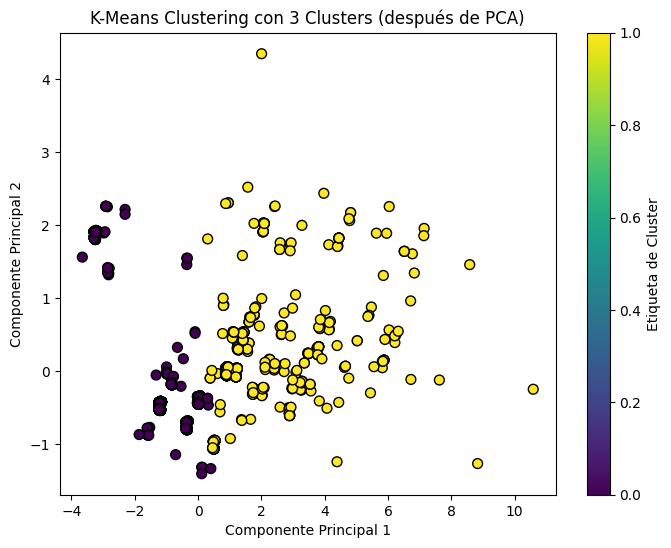

In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Suponiendo que ya tienes tu df_modelo_cluster escalado

# Reducir a 2 dimensiones usando PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_modelo_cluster)

# Aplicar K-Means con el número óptimo de clusters (4 clusters en este caso)
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(df_pca)

# Visualizar los clusters en 2D
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title(f'K-Means Clustering con {n_clusters} Clusters (después de PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Etiqueta de Cluster')
plt.show()


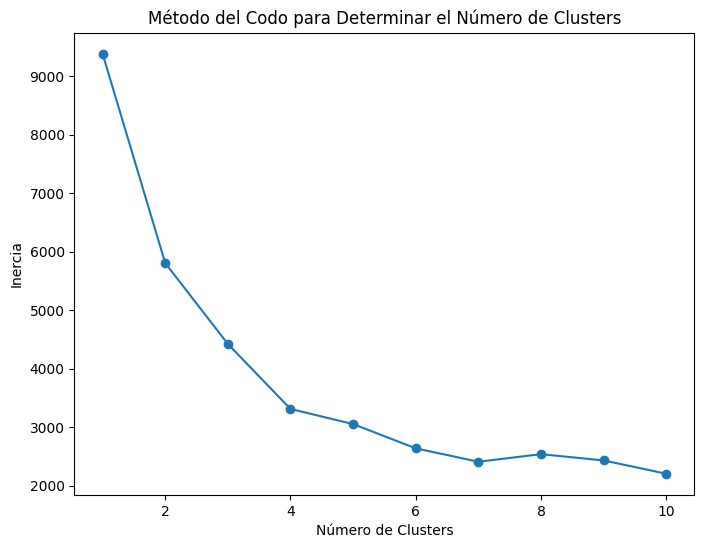

In [352]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Lista para almacenar la inercia (suma de los errores cuadráticos dentro de los clusters)
inertia = []
range_n_clusters = range(1, 11)  # Número de clusters a probar

# Probar diferentes números de clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(df_modelo_cluster)  # df_modelo_cluster debe estar escalado
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método del Codo para Determinar el Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()


#### Modelo clasificación para ver a que cluster pertenece

In [353]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Función para graficar la matriz de confusión
def graficar_matriz_confusion(y_test, y_pred, nombre_modelo):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Valores Reales')
    ax.set_title(f'Matriz de Confusión - {nombre_modelo}')
    plt.show()

# Función para realizar GridSearch con los hiperparámetros ajustados
def realizar_grid_search(modelo, X_train, y_train, nombre_modelo):
    parametros = {
        'LogisticRegression': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        },
        'KNeighborsClassifier': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        },
        'DecisionTreeClassifier': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10, 20]
        },
        'RandomForestClassifier': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10, 20]
        },
        'SVC': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        },
        'AdaBoostClassifier': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        },
        'GradientBoostingClassifier': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 7]
        }
    }

    # Si el modelo no tiene parámetros definidos, no se ejecuta GridSearch
    if nombre_modelo not in parametros:
        return modelo

    grid_search = GridSearchCV(estimator=modelo, param_grid=parametros[nombre_modelo], scoring='accuracy', cv=10, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    mejor_modelo = grid_search.best_estimator_
    mejor_score = grid_search.best_score_

    print(f"Mejor modelo encontrado para {nombre_modelo}: {mejor_modelo}")
    print(f"Mejor score (Accuracy) en GridSearchCV: {mejor_score}")

    return mejor_modelo


# Función para evaluar múltiples modelos de clasificación
def evaluate_classification_models(X, y, df_original, aplicar_gridsearch=True):
    # Suponemos que el df_original contiene la columna 'ID'
    ids = df_original['id_url']  # Mantener los IDs
    

    # Lista de modelos de clasificación
    modelos = [
        LogisticRegression(),
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        AdaBoostClassifier(),
        GradientBoostingClassifier()
    ]

    nombres = [
        'LogisticRegression',
        'KNeighborsClassifier',
        'DecisionTreeClassifier',
        'RandomForestClassifier',
        'SVC',
        'AdaBoostClassifier',
        'GradientBoostingClassifier'
    ]

    resultados = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall'])
    
    mejor_accuracy = -np.inf
    mejor_y_test = None
    mejor_y_pred = None
    mejor_ids_test = None  # Para almacenar los IDs del mejor modelo
    mejor_modelo = None
    mejor_nombre = None
    mejor_X_train = None
    mejor_y_train = None

    # Entrenar y evaluar cada modelo
    for modelo, nombre in zip(modelos, nombres):
        X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
            X, y, ids, test_size=0.2, random_state=42, stratify=y)

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Métricas para evaluar el modelo
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        if accuracy > mejor_accuracy:
            mejor_accuracy = accuracy
            mejor_y_test = y_test
            mejor_y_pred = y_pred
            mejor_ids_test = ids_test  # Guardar los IDs del mejor split
            mejor_modelo = modelo
            mejor_nombre = nombre
            mejor_X_train = X_train
            mejor_y_train = y_train

        modelo_df = pd.DataFrame({
            'Model': [nombre],
            'Accuracy': [accuracy],
            'F1-Score': [f1],
            'Precision': [precision],
            'Recall': [recall]
        })

        print(f'Modelo: {nombre}\nAccuracy: {accuracy}, F1-Score: {f1}, Precision: {precision}, Recall: {recall}\n')

        resultados = pd.concat([resultados, modelo_df], ignore_index=True)

    if aplicar_gridsearch:
        print(f"\nAplicando GridSearchCV al mejor modelo: {mejor_nombre}")
        mejor_modelo = realizar_grid_search(mejor_modelo, mejor_X_train, mejor_y_train, mejor_nombre)

    # Imprimir los valores reales y predicciones del mejor modelo
    df_resultado = pd.DataFrame({
        'ID': mejor_ids_test,
        'Valor Real': mejor_y_test,
        'Predicción': mejor_y_pred
    })

    print(f"\nResultados del mejor modelo {mejor_nombre} con IDs correspondientes:")
    print(df_resultado)

    # Graficar matriz de confusión para el mejor modelo
    graficar_matriz_confusion(mejor_y_test, mejor_y_pred, mejor_nombre)

    return df_resultado, mejor_modelo


In [354]:
def evaluate_classification_models_entrenado(X, y, df_original, aplicar_gridsearch=True):
    # Suponemos que el df_original contiene la columna 'ID'
    ids = df_original['id_url']  # Mantener los IDs
    
    # Lista de modelos de clasificación
    modelos = [
        LogisticRegression(),
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        AdaBoostClassifier(),
        GradientBoostingClassifier()
    ]

    nombres = [
        'LogisticRegression',
        'KNeighborsClassifier',
        'DecisionTreeClassifier',
        'RandomForestClassifier',
        'SVC',
        'AdaBoostClassifier',
        'GradientBoostingClassifier'
    ]

    resultados = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall'])
    
    mejor_accuracy = -np.inf
    mejor_y_test = None
    mejor_y_pred = None
    mejor_ids_test = None  # Para almacenar los IDs del mejor modelo
    mejor_modelo = None
    mejor_nombre = None
    mejor_X_train = None
    mejor_y_train = None

    # Entrenar y evaluar cada modelo
    for modelo, nombre in zip(modelos, nombres):
        X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
            X, y, ids, test_size=0.2, random_state=42, stratify=y)

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Métricas para evaluar el modelo
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        if accuracy > mejor_accuracy:
            mejor_accuracy = accuracy
            mejor_y_test = y_test
            mejor_y_pred = y_pred
            mejor_ids_test = ids_test  # Guardar los IDs del mejor split
            mejor_modelo = modelo
            mejor_nombre = nombre
            mejor_X_train = X_train
            mejor_y_train = y_train

        modelo_df = pd.DataFrame({
            'Model': [nombre],
            'Accuracy': [accuracy],
            'F1-Score': [f1],
            'Precision': [precision],
            'Recall': [recall]
        })

        print(f'Modelo: {nombre}\nAccuracy: {accuracy}, F1-Score: {f1}, Precision: {precision}, Recall: {recall}\n')

        resultados = pd.concat([resultados, modelo_df], ignore_index=True)

    if aplicar_gridsearch:
        print(f"\nAplicando GridSearchCV al mejor modelo: {mejor_nombre}")
        mejor_modelo = realizar_grid_search(mejor_modelo, mejor_X_train, mejor_y_train, mejor_nombre)

    # Imprimir los valores reales y predicciones del mejor modelo
    df_resultado = pd.DataFrame({
        'ID': mejor_ids_test,
        'Valor Real': mejor_y_test,
        'Predicción': mejor_y_pred
    })

    print(f"\nResultados del mejor modelo {mejor_nombre} con IDs correspondientes:")
    print(df_resultado)

    # Graficar matriz de confusión para el mejor modelo
    graficar_matriz_confusion(mejor_y_test, mejor_y_pred, mejor_nombre)

    # Retornar el DataFrame de resultados y el mejor modelo entrenado
    return df_resultado, mejor_modelo


In [355]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1431 entries, 2 to 1859
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unique_id              1431 non-null   object 
 1   title                  1431 non-null   object 
 2   city                   1431 non-null   object 
 3   guest_favorite         1431 non-null   int64  
 4   rating                 1431 non-null   float64
 5   number_reviews         1431 non-null   float64
 6   type_host              1431 non-null   object 
 7   hosting_time           1431 non-null   int64  
 8   price                  1431 non-null   float64
 9   all_reviews            1431 non-null   object 
 10  url                    1431 non-null   object 
 11  id_url                 1431 non-null   object 
 12  number_guest           1431 non-null   float64
 13  number_bedroom         1431 non-null   float64
 14  number_beds            1431 non-null   float64
 15  type_bath

Modelo: LogisticRegression
Accuracy: 0.9930313588850174, F1-Score: 0.9930416043755076, Precision: 0.9931616138591292, Recall: 0.9930313588850174

Modelo: KNeighborsClassifier
Accuracy: 0.9930313588850174, F1-Score: 0.9930313588850174, Precision: 0.9930313588850174, Recall: 0.9930313588850174

Modelo: DecisionTreeClassifier
Accuracy: 0.9965156794425087, F1-Score: 0.9965182980671398, Precision: 0.9965485503911643, Recall: 0.9965156794425087

Modelo: RandomForestClassifier
Accuracy: 0.9895470383275261, F1-Score: 0.9895620162912924, Precision: 0.9897161491238148, Recall: 0.9895470383275261

Modelo: SVC
Accuracy: 0.9895470383275261, F1-Score: 0.9895548942014191, Precision: 0.9895901547666719, Recall: 0.9895470383275261

Modelo: AdaBoostClassifier
Accuracy: 0.7839721254355401, F1-Score: 0.7582823241359826, Precision: 0.8386408448802095, Recall: 0.7839721254355401



/var/folders/7h/qmh6bk5x34g5j30ygn0wjywr0000gn/T/ipykernel_1991/24862598.py:71: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/silvanaruizmedina/Desktop/Bootcamp/airbnb/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Modelo: GradientBoostingClassifier
Accuracy: 1.0, F1-Score: 1.0, Precision: 1.0, Recall: 1.0


Aplicando GridSearchCV al mejor modelo: GradientBoostingClassifier
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Mejor modelo encontrado para GradientBoostingClassifier: GradientBoostingClassifier(learning_rate=1, n_estimators=50)
Mejor score (Accuracy) en GridSearchCV: 0.9973913043478261

Resultados del mejor modelo GradientBoostingClassifier con IDs correspondientes:
                       ID  Valor Real  Predicción
871    664692681829332904           0           0
75               50000091           2           2
926              14741430           0           0
1088             45948009           0           0
97     880548281073496058           0           0
...                   ...         ...         ...
1278             51044188           0           0
1212   975536549265419343           0           0
1178  1216083428705095008           0           0
429             

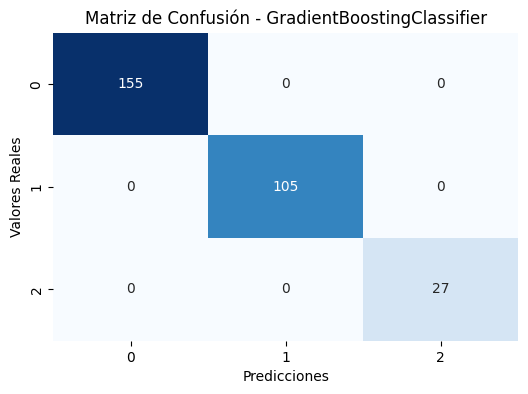

In [356]:
X = df_modelo_cluster.drop(columns='cluster')
y = df_modelo_cluster['cluster']
resultados, modelo_clasificacion = evaluate_classification_models_entrenado(X, y, df_modelo)

In [357]:
# Guarda el modelo de clasificación
with open('modelo_clasificacion.pkl', 'wb') as file:
    pickle.dump(modelo_clasificacion, file)

In [358]:
resultados

,ID,Valor Real,Predicción
871,664692681829332904,0,0
75,50000091,2,2
926,14741430,0,0
1088,45948009,0,0
97,880548281073496058,0,0
...,...,...,...
1278,51044188,0,0
1212,975536549265419343,0,0
1178,1216083428705095008,0,0
429,52932802,1,1


In [359]:
resultados.rename(columns={'ID': 'id_url'}, inplace=True)
#df_reseñas = pd.merge(resultados,  on='id_url', how='left') #Ver si se llama asi 

Entrenado este modelo ahora entreno el otrao modelo depediendo de los clusters

### Modelo para predecir precio

In [360]:
df_modelo

,unique_id,title,city,guest_favorite,rating,number_reviews,type_host,hosting_time,price,all_reviews,...,city_Austin,city_Charlotte,city_Chicago,city_Las vegas,city_Miami,city_San Francisco,city_Seattle,type_bathroom_private,type_bathroom_shared,type_bathroom_unknown
2,0064b7c5-d957-42ca-ab61-e4ae8e36d013,Stunning 2Bed Waterview Downtown,Miami,1,4.91,85.0,Superhost,120,359.0,"['Thanks again to Eva. Very responsive, met al...",...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,009db955-2045-4a1a-8d2a-283c67670180,Charming & Modern South Park Gem: Pool~Gym~Pkg,Charlotte,1,5.00,9.0,normal_host,2,74.0,['We had an amazing stay! The place was so bea...,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,00b1a711-fad5-4688-b895-0c0e183c1c44,Relaxing home in SouthEnd Area! Pets are welco...,Charlotte,0,4.69,237.0,Superhost,84,60.0,['Nice place to stay. Literally 15-20 mins fro...,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,00c126ac-9399-4c9c-ad04-ca1125758ade,Midcentury Farmhouse with Treehouse Cabin,Austin,1,4.99,231.0,Superhost,72,100.0,"[""We had a wonderful stay at Paul's guesthouse...",...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,00f14e20-7c06-4be8-97f9-6b2bd11093b2,Urban Oasis in Vibrant Gold Coast,Chicago,1,4.94,53.0,Superhost,60,182.0,['I had a great stay in a wonderful area of Ch...,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,ff2e5e9e-7b3b-47f7-a59c-99954c604b74,adorable suite,Chicago,1,4.87,60.0,Superhost,36,53.0,"[""my 8 day stay at Ricardo's place was very ni...",...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1856,ff4b46a6-0a10-4ecf-ab70-e50db752118a,Luxurious apartment in Miami,Miami,0,4.64,11.0,Superhost,24,60.0,['I been to a lot of airbnbs expensive ones at...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1857,ffa29e8c-bc7e-4e29-92df-3bf826dbfa41,Off Main Millhouse,Charlotte,1,4.96,238.0,Superhost,72,90.0,['We thoroughly enjoyed our stay in this adora...,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1858,ffc778da-391a-4247-8d58-9c1fe5da2210,At Mine | Oriental Zen Queen Suite in Miami,Miami,0,4.84,592.0,Superhost,24,59.0,['Location of the apartment not very good. Aft...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [361]:
df_precio = pd.concat([df_modelo_cluster, df_modelo[['price']]], axis=1)


In [362]:
df_precio

,guest_favorite,number_guest,number_bedroom,number_beds,number_bathroom,city_Austin,city_Charlotte,city_Chicago,city_Las vegas,city_Miami,city_San Francisco,city_Seattle,type_bathroom_private,type_bathroom_shared,type_bathroom_unknown,cluster,price
2,1,5.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,359.0
3,1,6.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,74.0
4,0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,60.0
5,1,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,100.0
6,1,2.0,1.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,182.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,53.0
1856,0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,60.0
1857,1,7.0,3.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,90.0
1858,0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,59.0


In [363]:
df_precio_cluster_0 = df_precio[df_precio['cluster'] == 0]  # DataFrame para cluster 0
df_precio_cluster_1 = df_precio[df_precio['cluster'] == 1]  # DataFrame para cluster 1
#df_precio_cluster_2 = df_precio[df_precio['cluster'] == 2]

In [364]:
def graficar_predicciones_vs_reales(y_test, y_pred, nombre_modelo):
    # Crear la figura
    fig = go.Figure()

    # Añadir la traza para los valores reales
    fig.add_trace(go.Scatter(
        x=y_test,
        y=y_pred,
        mode='markers',
        name='Predicciones',
        marker=dict(color='blue', size=10),
        hovertext=[f'Real: {real}<br>Predicción: {pred}' for real, pred in zip(y_test, y_pred)]
    ))

    # Añadir la línea de referencia (y=x) para facilitar la comparación
    fig.add_trace(go.Scatter(
        x=y_test,
        y=y_test,
        mode='lines',
        name='Valor Real',
        line=dict(color='red', dash='dash')
    ))

    # Configurar el layout del gráfico
    fig.update_layout(
        title=f'Predicciones vs Valores Reales - {nombre_modelo}',
        xaxis_title='Valores Reales',
        yaxis_title='Predicciones',
        width=700,
        height=500,
        showlegend=True,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    # Mostrar el gráfico
    fig.show()


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

def evaluate_models(X, y):
    # Lista de modelos de regresión
    modelos = [
        LinearRegression(),
        KNeighborsRegressor(),
        DecisionTreeRegressor(),
        RandomForestRegressor(),
        SVR(),
        AdaBoostRegressor(),
        GradientBoostingRegressor()
    ]

    nombres = [
        'LinearRegression',
        'KNeighborsRegressor',
        'DecisionTreeRegressor',
        'RandomForestRegressor',
        'SVR',
        'AdaBoostRegressor',
        'GradientBoostingRegressor'
    ]

    # DataFrame para acumular los resultados
    resultados = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'MAE'])
    
    # Definir variables para guardar el mejor modelo
    mejor_r2 = -np.inf  # R2 más alto es mejor
    mejor_y_test = None
    mejor_y_pred = None
    mejor_modelo = None
    mejor_nombre = None
    percentil_inferior = None
    percentil_superior = None

    # Entrenar y evaluar cada modelo
    for modelo, nombre in zip(modelos, nombres):
        # División del dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Entrenar el modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Métricas para evaluar el modelo
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        # Calcular los errores absolutos
        errores_absolutos = np.abs(y_test - y_pred)
        
        # Calcular percentiles
        p_inferior = np.percentile(errores_absolutos, 10)  # 10% más bajo
        p_superior = np.percentile(errores_absolutos, 90)  # 90% más alto

        # Guardar el mejor modelo según el R2
        if r2 > mejor_r2:
            mejor_r2 = r2
            mejor_y_test = y_test
            mejor_y_pred = y_pred
            mejor_modelo = modelo
            mejor_nombre = nombre
            percentil_inferior = p_inferior
            percentil_superior = p_superior

        # Crear un DataFrame con los resultados del modelo actual
        modelo_df = pd.DataFrame({
            'Model': [nombre],
            'R2': [r2],
            'RMSE': [rmse],
            'MAE': [mae],
            'Percentil Inferior (10%)': [p_inferior],
            'Percentil Superior (90%)': [p_superior]
        })

        # Mostrar las métricas
        print(f'Modelo: {nombre}\nR2: {r2}, RMSE: {rmse}, MAE: {mae}, Percentil Inferior: {p_inferior}, Percentil Superior: {p_superior}\n')
        resultados = pd.concat([resultados, modelo_df], ignore_index=True)

    # Imprimir los valores de y_test y y_pred del mejor modelo
    resultados_comparados = np.column_stack((mejor_y_test, mejor_y_pred))
    print("\nValores reales vs predicciones del mejor modelo:")
    print(resultados_comparados)

    # Graficar predicciones vs valores reales
    graficar_predicciones_vs_reales(mejor_y_test, mejor_y_pred, mejor_nombre)

    # Retornar resultados, datos de entrenamiento, el mejor modelo entrenado y los percentiles del error absoluto
    return resultados, X_train, y_train, mejor_modelo, percentil_inferior, percentil_superior






In [365]:
X= df_modelo.drop(columns=['rating', 'all_reviews', 'price','unique_id', 'url', 'id_url', 'city' , 'title', 'type_host', 'type_bathroom'])
y = df_modelo['price']
resultados_todo, X_train, y_train, mejor_modelo,percentil_inferior, percentil_superior = evaluate_models(X, y)

Modelo: LinearRegression
R2: 0.38205572359367723, RMSE: 46.59689892376859, MAE: 28.71493405358802, Percentil Inferior: 3.6665386556356565, Percentil Superior: 57.22600147204364

Modelo: KNeighborsRegressor
R2: 0.006153460172307557, RMSE: 59.09381427033985, MAE: 40.025087108013935, Percentil Inferior: 4.400000000000006, Percentil Superior: 84.56000000000002

Modelo: DecisionTreeRegressor
R2: 0.21960800443010198, RMSE: 52.36471702253507, MAE: 32.58710801393728, Percentil Inferior: 0.0, Percentil Superior: 81.40000000000003



/var/folders/7h/qmh6bk5x34g5j30ygn0wjywr0000gn/T/ipykernel_1991/381939984.py:136: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Modelo: RandomForestRegressor
R2: 0.49907217503268797, RMSE: 41.95366788256922, MAE: 26.101965156794428, Percentil Inferior: 1.5759999999999992, Percentil Superior: 56.656000000000006

Modelo: SVR
R2: -0.03765262211018161, RMSE: 60.38211928600666, MAE: 37.33892816354501, Percentil Inferior: 4.424991139559782, Percentil Superior: 77.429926177635

Modelo: AdaBoostRegressor
R2: 0.2194272425202589, RMSE: 52.37078128142633, MAE: 37.7645903143699, Percentil Inferior: 8.67863247863248, Percentil Superior: 60.78824457593689

Modelo: GradientBoostingRegressor
R2: 0.4941720050271179, RMSE: 42.158367824417795, MAE: 26.6744940881292, Percentil Inferior: 3.4517123561575973, Percentil Superior: 55.97609037766837


Valores reales vs predicciones del mejor modelo:
[[ 85.         115.4       ]
 [ 85.         100.42      ]
 [ 91.         102.24      ]
 [ 99.         112.25      ]
 [116.         115.1       ]
 [ 88.         112.31      ]
 [120.          80.86      ]
 [114.         155.04      ]
 [ 42.   

In [366]:
X= df_precio_cluster_0.drop(columns=['price', 'cluster'])
y = df_precio_cluster_0['price']
resultados_0, X_train, y_train, mejor_modelo_0, percentil_inferior_0, percentil_superior_0 = evaluate_models(X, y)

Modelo: LinearRegression
R2: 0.4023137770671964, RMSE: 29.01323885480823, MAE: 22.229166666666668, Percentil Inferior: 2.75, Percentil Superior: 47.875

Modelo: KNeighborsRegressor
R2: 0.36334683587691685, RMSE: 29.944084643351598, MAE: 22.023076923076925, Percentil Inferior: 3.4000000000000057, Percentil Superior: 48.5

Modelo: DecisionTreeRegressor
R2: 0.3039881159467287, RMSE: 31.308907847607877, MAE: 23.73471033006805, Percentil Inferior: 3.6779661016949206, Percentil Superior: 49.586184841701304

Modelo: RandomForestRegressor
R2: 0.38197216665515477, RMSE: 29.50282532377022, MAE: 22.552240134333918, Percentil Inferior: 3.2197865979283478, Percentil Superior: 48.96946992671313

Modelo: SVR
R2: 0.14226459464644348, RMSE: 34.75651785574781, MAE: 24.412230449314766, Percentil Inferior: 2.8923532517593102, Percentil Superior: 54.06261695257002

Modelo: AdaBoostRegressor
R2: 0.15224975190860468, RMSE: 34.5536200605211, MAE: 25.74644703722911, Percentil Inferior: 3.5, Percentil Superior:

/var/folders/7h/qmh6bk5x34g5j30ygn0wjywr0000gn/T/ipykernel_1991/381939984.py:136: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [367]:
with open('columnas_X.pkl', 'wb') as file:
    pickle.dump(X.columns, file)

In [368]:
X.columns

Index(['guest_favorite', 'number_guest', 'number_bedroom', 'number_beds',
       'number_bathroom', 'city_Austin', 'city_Charlotte', 'city_Chicago',
       'city_Las vegas', 'city_Miami', 'city_San Francisco', 'city_Seattle',
       'type_bathroom_private', 'type_bathroom_shared',
       'type_bathroom_unknown'],
      dtype='object')

In [369]:
with open('modelo_c0.pkl', 'wb') as file:
    pickle.dump(mejor_modelo_0, file)

In [370]:
with open('percentiles_modelo0.pkl', 'wb') as file:
    pickle.dump((percentil_inferior_0, percentil_superior_0), file)

In [371]:
X= df_precio_cluster_1.drop(columns=['price', 'cluster'])
y = df_precio_cluster_1['price']
resultados_1, X_train, y_train, mejor_modelo_1,  percentil_inferior_1, percentil_superior_1 = evaluate_models(X, y)

Modelo: LinearRegression
R2: 0.3232157405530155, RMSE: 46.215171888027974, MAE: 31.232177905096957, Percentil Inferior: 3.188248047718389, Percentil Superior: 73.87016653879387

Modelo: KNeighborsRegressor
R2: 0.09716003443176813, RMSE: 53.37831198601348, MAE: 35.756190476190476, Percentil Inferior: 5.400000000000006, Percentil Superior: 75.76000000000006

Modelo: DecisionTreeRegressor
R2: 0.251147471085194, RMSE: 48.613579303666896, MAE: 31.3818253968254, Percentil Inferior: 2.2566666666666664, Percentil Superior: 69.36000000000004

Modelo: RandomForestRegressor
R2: 0.32339671298966743, RMSE: 46.20899249530616, MAE: 30.384251429948403, Percentil Inferior: 3.0790836692838695, Percentil Superior: 66.21966666666668

Modelo: SVR
R2: -0.0017679183433834122, RMSE: 56.22675340531413, MAE: 36.26876555080413, Percentil Inferior: 4.9296036609544185, Percentil Superior: 92.35332891915915

Modelo: AdaBoostRegressor
R2: 0.2813632518946124, RMSE: 47.62271582382668, MAE: 37.11949009116663, Percentil

/var/folders/7h/qmh6bk5x34g5j30ygn0wjywr0000gn/T/ipykernel_1991/381939984.py:136: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [372]:
with open('percentiles_modelo1.pkl', 'wb') as file:
    pickle.dump((percentil_inferior_1, percentil_superior_1), file)

In [373]:
with open('modelo_c1.pkl', 'wb') as file:
    pickle.dump(mejor_modelo_1, file)

In [374]:
X= df_precio_cluster_2.drop(columns=['price', 'cluster'])
y = df_precio_cluster_2['price']
resultados_2, X_train, y_train, mejor_modelo_2,  percentil_inferior_2, percentil_superior_2 = evaluate_models(X, y)

Modelo: LinearRegression
R2: 0.4224432654935719, RMSE: 11.21964488386192, MAE: 9.427565751224101, Percentil Inferior: 1.9841246190371535, Percentil Superior: 17.86410799967819


/var/folders/7h/qmh6bk5x34g5j30ygn0wjywr0000gn/T/ipykernel_1991/381939984.py:136: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




Modelo: KNeighborsRegressor
R2: 0.18664216303308, RMSE: 13.314431045826709, MAE: 10.725925925925926, Percentil Inferior: 1.2000000000000028, Percentil Superior: 20.560000000000002

Modelo: DecisionTreeRegressor
R2: 0.22438865647306783, RMSE: 13.00181137271322, MAE: 10.321107314979864, Percentil Inferior: 1.2333333333333358, Percentil Superior: 20.837500000000002

Modelo: RandomForestRegressor
R2: 0.3484266413441768, RMSE: 11.916904099053768, MAE: 9.518307531285329, Percentil Inferior: 1.3602647485847656, Percentil Superior: 19.635154597766096

Modelo: SVR
R2: -0.15150236613021661, RMSE: 15.842152967023988, MAE: 12.799640642097874, Percentil Inferior: 2.803112283203339, Percentil Superior: 26.276458977246563

Modelo: AdaBoostRegressor
R2: 0.322499850944047, RMSE: 12.151684426765076, MAE: 9.108827281756609, Percentil Inferior: 1.3050847457627128, Percentil Superior: 21.200000000000003

Modelo: GradientBoostingRegressor
R2: 0.33292364247016626, RMSE: 12.057841183753432, MAE: 9.6586847137

In [375]:
with open('modelo_c2.pkl', 'wb') as file:
    pickle.dump(mejor_modelo_2, file)

In [376]:
with open('percentiles_modelo2.pkl', 'wb') as file:
    pickle.dump((percentil_inferior_2, percentil_superior_2), file)

con cv=10